# Preprocessing notebook : build melspectrograms from audio files

**Input :** audio files in `data/data`  
**Output :** melspectrograms of size $313\times128$ in `data/Features/melspec_313_128/`



## Import packages

In [37]:
%matplotlib inline
import librosa
import librosa.display
import IPython.display as ipd
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from tqdm import tqdm

## Choose the paths

In [29]:
# Enter the path to audio data
PATH_DATASET = "../data/data"
# Enter the path where spectrograms will be saved
PATH_FEATURES = '../data/Features/'
PATH_MELSPEC = PATH_FEATURES + 'melspec_313_128/'

## Function to build the dataframe of file names with their features for each machine type

In [26]:
#Get list of files in train and test directory
def get_df_files(machine_str):

    path_train_folder = PATH_DATASET + "/dev_" + machine_str + "/" + machine_str + "/train"
    path_test_folder = PATH_DATASET  + "/dev_" + machine_str + "/" + machine_str + "/test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "/" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder + "/" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]
        })

    #Get file dataframe
    df_files = pd.DataFrame(list_dict_file)
    
    return df_files


## Functions to compute and save the spectograms

In [40]:
def build_melspectrogram(audio_name, spectro_params):
    #Get audio array
    audio_array, sr = librosa.load(audio_name, sr=None)

    #Get mel spectogram
    melspectrogram = librosa.feature.melspectrogram(
        y = audio_array, 
        n_fft = spectro_params['n_fft'], 
        hop_length = spectro_params['hop_length'], 
        n_mels = spectro_params['n_mels']
    )
    # Express in decibel units
    melspectrogram = librosa.power_to_db(melspectrogram, ref=1e-12)   #  ref=np.max 
    # Flatten the spectrogram
    #print("Initial Spectro shape = ", melspectrogram.shape)
    melspectrogram = melspectrogram.reshape(1, -1)
    #print("Final Spectro shape = ", melspectrogram.shape)
    
    return melspectrogram


def compute_and_save_spectros(machine_str, spectro_params):
    # Check or create folders
    if not os.path.exists(PATH_FEATURES):
        os.makedirs(PATH_FEATURES)

    if not os.path.exists(PATH_MELSPEC):
        os.makedirs(PATH_MELSPEC)

    path_machine_folder = PATH_MELSPEC + machine_str + '/'
    if not os.path.exists(path_machine_folder):
        os.makedirs(path_machine_folder)
        
    # Get the dataframe of files for this machine
    df = get_df_files(machine_str)
    
    # Loop through the dataframe
    for idx, row in df.iterrows():
        # Get audio array
        audio_path = row['filepath']
        # Build the spectrogram
        melspectrogram = build_melspectrogram(audio_path, spectro_params)   
        # Save 
        filename = path_machine_folder + row['filename'].split('.wav')[0]
        np.save(filename, melspectrogram)


Test

In [34]:
audio_name = '../data/data/dev_slider/slider/train/section_00_source_train_normal_0002_vel_900.wav'

spectro_params = dict(
    n_fft = 1024, 
    hop_length = 512, 
    n_mels=128
)

spectro = build_melspectrogram(audio_name, spectro_params)


Initial Spectro shape =  (128, 313)
Final Spectro shape =  (1, 40064)


## Run it for all machine types

In [41]:
spectro_params = dict(
    n_fft = 1024,     # length of the FFT window
    hop_length = 512,    # number of samples between successive frames
    n_mels = 128       # number of Mel bands to generate
)

machines_list = ['valve', 'bearing', 'fan', 'slider', 'gearbox', 'ToyCar', 'ToyTrain']

for machine in tqdm(machines_list):
    compute_and_save_spectros(machine, spectro_params)

100%|██████████| 7/7 [04:33<00:00, 39.05s/it]


## Plot one spectrogram for test

In [51]:
def plot_spectro(filepath):
    # Load the original melspectogram array
    spectro_array = np.load(filepath).reshape(128, 313)
    # Plot the spectrogram
    librosa.display.specshow(spectro_array, sr = 16000, x_axis = 'time', y_axis = 'mel', cmap = 'magma')


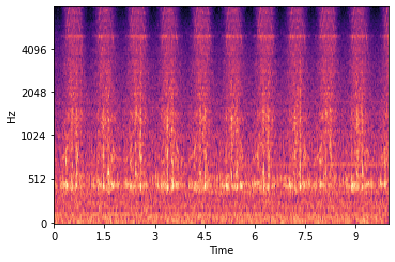

In [52]:
path = '../data/Features/melspec_313_128/slider/section_00_source_test_anomaly_0000_vel_1100.npy'
plot_spectro(path)